In [1]:
# Data Cleaning and Preprocessing - minimal EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cso_lab.data import load_spot, load_futures, load_vol_surface, load_correlation

%matplotlib inline
sns.set_style("whitegrid")


Loaded /Users/amankesarwani/PycharmProjects/cso-lab/data/synthetic/spot_series.csv -> 3000 rows, columns: ['spot', 'wti_spot']
Missing values per column:
spot        0
wti_spot    0
dtype: int64
spot.head():


,spot,wti_spot
date,,
2015-01-01,3.640385,58.972519
2015-01-02,3.375715,61.146471
2015-01-03,3.204933,55.785116
2015-01-04,3.662518,54.507166
2015-01-05,4.360692,53.385490



spot.describe():


,spot,wti_spot
count,3000.000000,3000.000000
mean,3.130392,63.746519
std,1.178749,7.745473
min,-1.354460,39.619483
25%,2.336809,58.511653
50%,3.117760,63.885690
75%,3.915493,69.170478
max,7.128895,86.949808


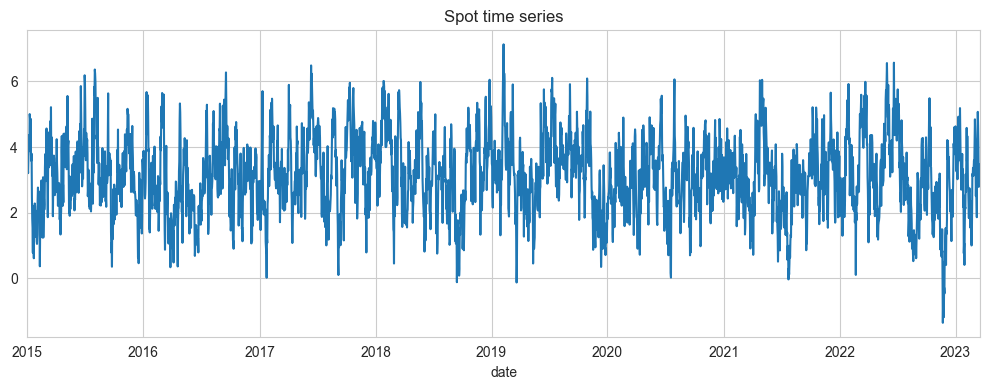

In [2]:
#
# Cell 2: Load spot series and quick checks
#
# %%
spot = load_spot("spot_series")   # will search data/synthetic -> data/processed -> data/raw
print("spot.head():")
display(spot.head())
print("\nspot.describe():")
display(spot.describe())
plt.figure(figsize=(10, 4))
if "spot" in spot.columns:
    spot["spot"].plot(title="Spot time series")
else:
    spot.iloc[:, 0].plot(title="Spot (first numeric column)")
plt.tight_layout()

In [3]:
#
# Cell 3: Missing values summary
#
# %%
print("Missing values per column (spot):")
display(spot.isna().sum())


Missing values per column (spot):


spot        0
wti_spot    0
dtype: int64

futures sample:


,date,contract,price
0,2015-01-01,1m,59.765007
1,2015-01-02,1m,59.644459
2,2015-01-03,1m,59.661405
3,2015-01-04,1m,60.709540
4,2015-01-05,1m,60.204177


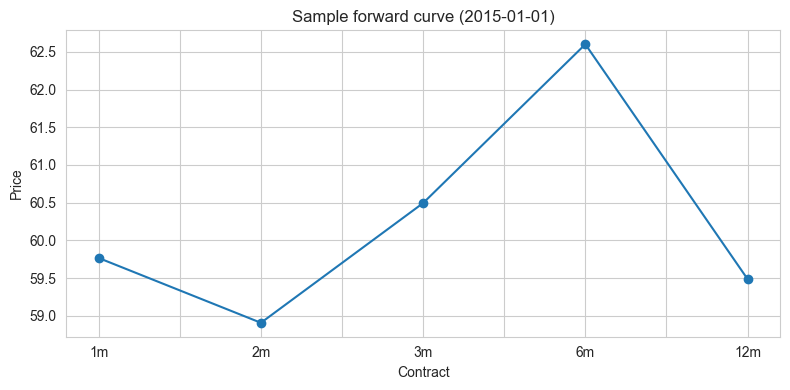

In [4]:
# python
# Cell 4: Load futures (WTI tenor wide file) and show sample forward curves (robust to missing 'price')
import re
import pandas as pd
import matplotlib.pyplot as plt
from cso_lab.data import load_futures

futs = load_futures("wti_futures_curves")
print("futures sample:")
display(futs.head())

df = futs.copy()

# bring datetime index out if necessary
if df.index.name and pd.api.types.is_datetime64_any_dtype(df.index):
    df = df.reset_index().rename(columns={df.index.name: "date"})

# find date column (case-insensitive)
date_cols = [c for c in df.columns if c.lower() == "date"]
date_col = date_cols[0] if date_cols else None
if date_col:
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

# Case A: already long-format with date, contract, price
if "contract" in df.columns and "price" in df.columns:
    cols = []
    if date_col:
        cols.append(date_col)
    cols += ["contract", "price"]
    long = df[cols].copy()
    if date_col:
        long = long.rename(columns={date_col: "date"})
    else:
        long["date"] = pd.NaT

# Case B: long-format with contract and some value column (not named price)
elif "contract" in df.columns:
    # try to find candidate price column among common names or numeric columns
    candidates = ["value", "val", "close", "mid", "last", "px", "price_usd"]
    found = None
    for c in candidates:
        if c in df.columns:
            found = c
            break
    if found:
        long = df[[date_col] if date_col else [] + ["contract", found]].copy()
        long = long.rename(columns={found: "price"})
        if not date_col:
            long["date"] = pd.NaT
    else:
        # pick first numeric column besides contract/date
        num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) and c not in ([date_col] if date_col else []) + ["contract"]]
        if num_cols:
            long = df[[date_col] if date_col else [] + ["contract", num_cols[0]]].copy()
            long = long.rename(columns={num_cols[0]: "price"})
            if not date_col:
                long["date"] = pd.NaT
        else:
            long = pd.DataFrame(columns=["date", "contract", "price"])

# Case C: wide tenor columns -> melt to long
else:
    tenor_re = re.compile(r"^(?:tenor_)?_?(\d+)m$", re.IGNORECASE)
    tenor_cols = [c for c in df.columns if tenor_re.match(c)]
    if tenor_cols and date_col:
        long = df.melt(
            id_vars=[date_col],
            value_vars=tenor_cols,
            var_name="tenor",
            value_name="price",
        ).rename(columns={date_col: "date"})
        long["contract"] = (
            long["tenor"]
            .str.replace(r"^(?:tenor_)?_?", "", regex=True)
            .str.lower()
            .apply(lambda s: s if s.endswith("m") else f"{s}m")
        )
        long = long[["date", "contract", "price"]]
    else:
        print("Could not detect long or wide tenor format in `futs`. Columns:", list(df.columns))
        long = pd.DataFrame(columns=["date", "contract", "price"])

# Ensure a 'price' column exists: rename common alternatives or pick first numeric column if present
if "price" not in long.columns:
    alt_candidates = ["value", "val", "close", "mid", "last", "px", "price_usd"]
    renamed = False
    for c in alt_candidates:
        if c in long.columns:
            long = long.rename(columns={c: "price"})
            renamed = True
            break
    if not renamed:
        numeric_candidates = [c for c in long.columns if pd.api.types.is_numeric_dtype(long[c]) and c not in ["price", "date", "contract", "tenor"]]
        if numeric_candidates:
            long = long.rename(columns={numeric_candidates[0]: "price"})
        else:
            # ensure the DataFrame has the expected columns to avoid KeyError downstream
            long = long.reindex(columns=["date", "contract", "price"])

# coerce price to numeric only if present
if "price" in long.columns:
    long["price"] = pd.to_numeric(long["price"], errors="coerce")

# pick first available non-null date and build forward curve
fc = None
sample_date = None
if "date" in long.columns and long["date"].notna().any():
    unique_dates = pd.to_datetime(long["date"].dropna().unique())
    if len(unique_dates):
        sample_date = unique_dates[0]
        fc = long[long["date"] == sample_date].pivot_table(index="contract", values="price", aggfunc="first")
elif not long.empty and "date" not in long.columns:
    # no date column but data present: group by contract and take first value
    fc = long.pivot_table(index="contract", values="price", aggfunc="first")

# helper to sort contracts by numeric tenor when possible (e.g. '1m' -> 1)
def tenor_months(contract):
    if pd.isna(contract):
        return 1e9
    m = re.search(r"(\d+)", str(contract))
    return int(m.group(1)) if m else 1e9

if fc is not None and not fc.empty:
    sorted_index = sorted(fc.index, key=tenor_months)
    fc = fc.reindex(sorted_index)
    plt.figure(figsize=(8, 4))
    fc["price"].plot(marker="o")
    title_date = sample_date.strftime("%Y-%m-%d") if hasattr(sample_date, "strftime") else sample_date
    plt.title(f"Sample forward curve ({title_date})" if sample_date is not None else "Sample forward curve")
    plt.ylabel("Price")
    plt.xlabel("Contract")
    plt.tight_layout()
    plt.show()
else:
    print("Could not construct a forward curve - no valid price/contract/date combination found. `long` columns:", list(long.columns))


In [5]:

# Cell 5: Vol surface quick check
#
# %%
vol = load_vol_surface("vol_surface_hh")
print("vol.head():")
display(vol.head())
print("\nMissing values per column (vol):")
display(vol.isna().sum())


Loaded /Users/amankesarwani/PycharmProjects/cso-lab/data/synthetic/vol_surface_hh.csv -> 12 rows, columns: ['expiry', 'strike', 'iv']
Missing values per column:
expiry    0
strike    0
iv        0
dtype: int64
vol.head():


,expiry,strike,iv
0,0.25,-0.5,0.596685
1,0.25,0.0,0.624614
2,0.25,0.5,0.626147
3,0.25,1.0,0.733366
4,0.50,-0.5,0.604478



Missing values per column (vol):


expiry    0
strike    0
iv        0
dtype: int64

In [6]:

#
# Cell 6: Correlation quick check
#
# %%
corr = load_correlation("correlation")
print("correlation head:")
display(corr.head())
print("\nMissing values per column (correlation):")
display(corr.isna().sum())

Loaded /Users/amankesarwani/PycharmProjects/cso-lab/data/synthetic/correlation.csv -> 1500 rows, numeric cols: ['corr_hh_wti']
Missing values per column:
corr_hh_wti    0
dtype: int64
correlation head:


,corr_hh_wti
date,
2015-01-01,0.277133
2015-01-02,0.319124
2015-01-03,0.345981
2015-01-04,0.307913
2015-01-05,0.333359



Missing values per column (correlation):


corr_hh_wti    0
dtype: int64